1) An expert can understand a set of one features as a concept, whereas for a black-box model a concept in unsupervised setting will be a set of absolutely different features (correlated ones and so on)
   

In [10]:
import scipy
import joblib
import sklearn
import numpy as np
import pandas as pd
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler 
import tensorflow as tf

from tabcbm.models.architectures import construct_encoder, construct_decoder
from tabcbm.models.architectures import construct_end_to_end_model
from tabcbm.models.tabcbm import TabCBM

# Read the data 

In [11]:
# Reading already preprocessed train and test data 

data_dir = 'D:\\PycharmProjects\\AMMISproject\\data\\processed_data'
dataset = 'dataco'

x_train_std = joblib.load(osp.join(data_dir, dataset, 'x_train_std.joblib'))
x_test_std = joblib.load(osp.join(data_dir, dataset, 'x_test_std.joblib'))

x_train = joblib.load(osp.join(data_dir, dataset, 'x_train.joblib'))
x_test = joblib.load(osp.join(data_dir, dataset, 'x_test.joblib'))

y_train = joblib.load(osp.join(data_dir, dataset, 'y_train.joblib'))
y_test = joblib.load(osp.join(data_dir, dataset, 'y_test.joblib'))

print('Shape of the training set: ', x_train_std.shape)
print('Shape of the test set: ', x_test_std.shape)
print('Shape of the trainigb targets: ', y_train.shape)


Shape of the training set:  (120935, 40)
Shape of the test set:  (51830, 40)
Shape of the trainigb targets:  (120935,)


In [4]:
rus = RandomUnderSampler(sampling_strategy='all', random_state=0)

x_train_reduced, y_train_reduced = rus.fit_resample(x_train_std, y_train) 
x_train_reduced.shape

(103416, 40)

In [12]:
# Defining the concepts 

aggregated_concepts = {
    'Shipment': ['Type', 'Days for shipment (scheduled)', 'Shipping Mode', 'Distance (km)'],
    'Customer': ['Customer Zipcode', 'Customer Segment'],
    'Department': ['Department Name', 'Market'],
    'Store': ['Store Latitude', 'Store Longitude'],
    'Order': ['Order Id', 'Order Longitude', 'Order Latitude',
              'Benefit per order', 'Order Item Total', 'Order Status', 'Sales', 
              'Order Item Discount', 'order_year', 'order_month', 'order_day'],
    'Product': ['Category Name']
}

# In the preprocessed data the naming of the columns differs, so we have to define
# expanded features and put them as a value of a corresponding concept
extended_concepts = {}
for concept, features in aggregated_concepts.items():
    extended_features = []
    for value in features:
            [extended_features.append(column) for column in x_train_std.columns if value in column]
   
    extended_concepts[concept] = extended_features


In [13]:
# Creating masks for each concept 

concepts_num = len(aggregated_concepts)
all_features = x_train_std.columns

total_features_num = len(all_features) 

concepts_masks = pd.DataFrame(0, columns=all_features, index=list(aggregated_concepts.keys()))

for concept, features in extended_concepts.items():
    for feature in features:
        concepts_masks.loc[concept, feature] = 1

In [14]:
concepts_masks

,Days for shipment (scheduled),Category Name,Customer Zipcode,Department Name,Store Latitude,Store Longitude,Sales,Order Id,Order Item Discount,Benefit per order,...,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING
Shipment,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
Customer,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Department,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Store,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Order,0,0,0,0,0,0,1,1,1,1,...,0,0,0,1,1,1,1,1,1,1
Product,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create main components for TabCBM

In [15]:
x_train = x_train_reduced
y_train = y_train_reduced

x_test = x_test_std

In [43]:
# Parameters defining the architecture we will use

input_shape = x_train_std.shape[1:]
num_outputs = len(set(y_train))
encoder_units = [16, 16]
decoder_units = [16]
latent_dims = 16
learning_rate = 0.001
validation_size = 0.1

print('Input shape: ', input_shape)
print('Number of outputs: ', num_outputs)

Input shape:  (40,)
Number of outputs:  2


## The end-to-end model

In [44]:
# Next, we build the feature to latent code encoder model (i.e., phi)
encoder = construct_encoder(input_shape, encoder_units, latent_dims)

In [45]:
# Then, we build the concept to label model  (i.e., the label predictor f)

decoder_inputs = tf.keras.Input(shape=[latent_dims])
decoder_graph = construct_decoder(decoder_units, num_outputs)
decoder = tf.keras.Model(
    decoder_inputs,
    decoder_graph(decoder_inputs),
    name="decoder",
)

In [46]:
# We then put them both together to make an end-to-end model we can pretrain

end_to_end_model, encoder, decoder = construct_end_to_end_model(input_shape,
                                                                encoder,
                                                                decoder,
                                                                num_outputs,
                                                                learning_rate)

#end_to_end_model.summary()

pretrain_epochs = 50
batch_size = 512
pretrain_hist = end_to_end_model.fit(
    x=x_train,
    y=y_train,
    epochs=pretrain_epochs,
    batch_size=batch_size,
    validation_split=validation_size,
    verbose=1,
)

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.5964 - loss: 0.6619 - val_binary_accuracy: 0.4914 - val_loss: 0.6457
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7315 - loss: 0.5366 - val_binary_accuracy: 0.4928 - val_loss: 0.6821
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7405 - loss: 0.5293 - val_binary_accuracy: 0.5114 - val_loss: 0.6953
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7420 - loss: 0.5282 - val_binary_accuracy: 0.5185 - val_loss: 0.6687
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7443 - loss: 0.5264 - val_binary_accuracy: 0.5157 - val_loss: 0.6884
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7442 - loss: 0.5256 - val_binary_accuracy: 0.5111 - val_loss: 0.6742
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7424 - loss: 0.5273 - val_binary_accuracy: 0.5256 - val_loss: 0.6989
Epoch 

## Model evaluation

In [47]:
# Evaluate pretrained model

# We will accumulate all metrics/results in the same dictionary
results = {}

end_to_end_preds = end_to_end_model.predict(
    x_test,
    batch_size=batch_size,
)

# We assume that we have outputed logits
if np.min(end_to_end_preds) < 0.0 or np.max(end_to_end_preds) > 1:
    end_to_end_preds = tf.math.sigmoid(end_to_end_preds).numpy()
end_to_end_preds = (end_to_end_preds >= 0.5).astype(np.int32)
results['pre_train_acc'] = sklearn.metrics.accuracy_score(
    y_test,
    end_to_end_preds,
)
results['pre_train_auc'] = sklearn.metrics.roc_auc_score(
    y_test,
    end_to_end_preds,
)
print(f"Pretrained model task accuracy: {results['pre_train_acc']*100:.2f}%")


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Pretrained model task accuracy: 69.33%


# Construct TabCBM

For this, we will first compute the empirical covariance matrix in order for us to learn useful masks using a similar approach to that proposed by SEFS:

In [49]:
# Construct the training set's empirical covariance matrix
# NOTE: This step can be very computationally expensive/intractable in large
#       datasets. In those cases, one may ignore the covariance matrix when
#       performing TabCBM's pretraining at the potential cost of performance or
#       more accurate concept discovery.
cov_mat = np.corrcoef(x_train.T)
print(cov_mat)

[[ 1.00000000e+00 -1.52359525e-03  7.25428431e-03 ... -1.29613472e-03
   1.91737188e-03  2.85895405e-04]
 [-1.52359525e-03  1.00000000e+00  2.95561135e-03 ...  1.34743379e-03
  -1.89628924e-04 -5.51330419e-03]
 [ 7.25428431e-03  2.95561135e-03  1.00000000e+00 ... -2.07049065e-03
   4.44164717e-03  4.52410512e-03]
 ...
 [-1.29613472e-03  1.34743379e-03 -2.07049065e-03 ...  1.00000000e+00
  -1.99119351e-01 -1.39314429e-01]
 [ 1.91737188e-03 -1.89628924e-04  4.44164717e-03 ... -1.99119351e-01
   1.00000000e+00 -2.08762719e-01]
 [ 2.85895405e-04 -5.51330419e-03  4.52410512e-03 ... -1.39314429e-01
  -2.08762719e-01  1.00000000e+00]]


In [50]:
# Number of concepts we want to discover
n_concepts = 6

# Set the weights for the different regularisers in the loss
coherence_reg_weight = 0.1  # $lambda_{co}
diversity_reg_weight = 5  # $lambda_{div}
feature_selection_reg_weight = 5  # $lambda_{spec}
gate_estimator_weight = 10  # Gate prediction regularizer for SEFS's pre-text task

# Select how many neighbors to use for the coherency loss (must be less than the batch size!)
top_k = 256

In [51]:
# Generate a dictionary with the parameters to use for TabCBM as we will have
# to use the same parameters twice:
tab_cbm_params = dict(
    features_to_concepts_model=encoder,  # The $\phi$ sub-model
    concepts_to_labels_model=decoder,  # The $f$ sub-model
    latent_dims=latent_dims,  # The dimensionality of the concept embeddings $m$
    n_concepts=n_concepts,  # The number of concepts to discover $k^\prime$
    cov_mat=cov_mat,  # The empirical covariance matrix
    loss_fn=end_to_end_model.loss,  # The downstream task loss function
    # Then we provide all the regularizers weights
    coherence_reg_weight=coherence_reg_weight,
    diversity_reg_weight=diversity_reg_weight,
    feature_selection_reg_weight=feature_selection_reg_weight,
    gate_estimator_weight=gate_estimator_weight,
    top_k=top_k,

    # And indicate that we will not be providing any supervised concepts! Change
    # this is training concepts (e.g., `c_train`) are provided/known during
    # training
    n_supervised_concepts=0,
    concept_prediction_weight=0,

    # The accuracy metric to use for logging performance
    acc_metric=(
        lambda y_true, y_pred: tf.math.reduce_mean(
            tf.keras.metrics.sparse_categorical_accuracy(
                y_true,
                y_pred,
            )
        )
    ),

    # ANd architectural details of the self-supervised reconstruction modules
    concept_generator_units=[64],
    rec_model_units=[64],
)

In [52]:
# Mask Generator Self-supervised Training

# Next, we proceed to do the SELF-SUPERVISED TRAINING of the MASK
# GENERATORS for TabCBM. For this, we will follow a similar approach
# to that of SEFS. Our TabCBM module allows one to do this by setting
# the self_supervised_mode flag to True before calling the .fit() method:

# We can now construct our TabCBM model which we will first self-supervise!
ss_tabcbm = TabCBM(self_supervised_mode=True,  **tab_cbm_params)
ss_tabcbm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate,))
ss_tabcbm.summary()


[WARNING] Assuming independence between features in TabCBM training.


d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "tab_cbm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Functional)            │ (None, 1)              │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 16)             │        11,516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_0            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rec_values_model_0 (Sequential) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rec_mask_model (Sequential)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_1            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_2            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_3            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_4            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_5            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,485 (52.68 KB)

 Trainable params: 13,245 (51.74 KB)

 Non-trainable params: 240 (960.00 B)

In [53]:
self_supervised_train_epochs = 50
print("TabCBM self-supervised training stage...")
ss_tabcbm_hist = ss_tabcbm.fit(
    x=x_train,
    y=y_train,
    validation_split=validation_size,
    epochs=self_supervised_train_epochs,
    batch_size=batch_size,
    verbose=1,
)

print("\tTabCBM self-supervised training completed")

TabCBM self-supervised training stage...
Epoch 1/50


d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.0677 - avg_mask_rec_loss: 6.8836 - loss: 47.7076 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1085 - val_avg_mask_rec_loss: 6.6812 - val_loss: 46.7383
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.1220 - avg_mask_rec_loss: 6.4611 - loss: 45.4988 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1847 - val_avg_mask_rec_loss: 5.8501 - val_loss: 42.2090
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [54]:
# First we will instantiate a new TabCBM that is NOT in self-supervised mode,
# and we will load its weights so that they are the same as the model whose
# mask generators have been pre-trained using the SS loss.
tabcbm_supervised = TabCBM(
    self_supervised_mode=False,
    # Notice how we provide as concept generators the concept generators of the
    # SS TabCBM:
    concept_generators=ss_tabcbm.concept_generators,
    # as well as the feature probability masks:
    prior_masks=ss_tabcbm.feature_probabilities,
    **tab_cbm_params,
)
tabcbm_supervised.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
tabcbm_supervised.summary()

[WARNING] Assuming independence between features in TabCBM training.


d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "tab_cbm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Functional)            │ (None, 1)              │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 16)             │        11,516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_0            │ (None, 16)             │         3,664 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_1            │ (None, 16)             │         3,664 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_2            │ (None, 16)             │         3,664 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_3            │ (None, 16)             │         3,664 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_4            │ (None, 16)             │         3,664 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_5            │ (None, 16)             │         3,664 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,469 (138.55 KB)

 Trainable params: 35,229 (137.61 KB)

 Non-trainable params: 240 (960.00 B)

In [55]:
max_epochs = 150   
print("TabCBM self-supervised training stage...")

tabcbm_hist = tabcbm_supervised.fit(
    x=x_train,
    y=y_train,
    validation_split=validation_size,
    epochs=max_epochs,
    batch_size=batch_size,
    verbose=1,
)

print("\tTabCBM supervised training completed")

TabCBM self-supervised training stage...
Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.5527 - avg_concept_size: 18.4764 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 3.4222 - max_probability: 0.7212 - mean_probability: 0.4852 - min_probability: 0.2628 - prob_sparsity_loss: 2.4259 - reg_loss_closest: 0.0058 - reg_loss_similarity: 0.4246 - task_loss: 0.5775 - val_accuracy: 0.0000e+00 - val_loss: 3.2125 - val_prob_sparsity_loss: 2.2685 - val_reg_loss_closest: 0.0044 - val_reg_loss_similarity: 0.2901 - val_task_loss: 0.6582
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5574 - avg_concept_size: 14.4190 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 3.0213 - max_probability: 0.6823 - mean_probability: 0.4433 - min_probability: 0.2318 - prob_sparsity_loss: 2.2165 - reg_loss_closest: 0.0097 - reg_loss_similarity: 0.2793 - task_loss: 0.5352 - val_accuracy: 0.0000e+00 - val_loss: 2.9173 - val_

## HPO for TabCBM

In [77]:
def evaluate_tabcbm(model, x_test, y_test, batch_size, threshold_auc=False):
    test_y_pred, test_concept_scores = model.predict(x_test, batch_size=batch_size)
    # Then we assume that we have outputed logits
    test_preds = tf.math.sigmoid(test_y_pred).numpy()
        
    test_preds_bin = (test_preds > 0.5).astype(np.int32)
    results['acc'] = sklearn.metrics.accuracy_score(y_test, test_preds_bin)
    if threshold_auc:
        results['auc'] = sklearn.metrics.roc_auc_score(y_test, test_preds_bin)
    else:
        results['auc'] = sklearn.metrics.roc_auc_score(y_test, test_preds)

    print(f"Accuracy is {results['acc']*100:.2f}%")
    print(f"ROC-AUC is {results['auc']*100:.2f}%")
    return results

In [68]:
n_concepts_list = [8, 10, 12] 
coherence_reg_weight = 0.1
diversity_reg_weight = 5
feature_selection_reg_weight = 5
gate_estimator_weight = 10  
top_k = 256  # (must be less than the batch size!)


best_model = None
best_auc = 0

tabcbms_k_optimized = {}

for n_concepts in n_concepts_list:
    # Generate a dictionary with the parameters to use for TabCBM as we will have
    # to use the same parameters twice:
    tab_cbm_params = dict(
        features_to_concepts_model=encoder,  # The $\phi$ sub-model
        concepts_to_labels_model=decoder,  # The $f$ sub-model
        latent_dims=latent_dims,  # The dimensionality of the concept embeddings $m$
        n_concepts=n_concepts,  # The number of concepts to discover $k^\prime$
        cov_mat=cov_mat,  # The empirical covariance matrix
        loss_fn=end_to_end_model.loss,  # The downstream task loss function

        coherence_reg_weight=coherence_reg_weight,
        diversity_reg_weight=diversity_reg_weight,
        feature_selection_reg_weight=feature_selection_reg_weight,
        gate_estimator_weight=gate_estimator_weight,
        top_k=top_k,
        n_supervised_concepts=0,
        concept_prediction_weight=0,

        acc_metric=(
            lambda y_true, y_pred: tf.math.reduce_mean(
                tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
            )
        ),

        # ANd architectural details of the self-supervised reconstruction modules
        concept_generator_units=[64],
        rec_model_units=[64],
    )

    tabcbm_unsup = TabCBM(self_supervised_mode=True,  **tab_cbm_params)
    tabcbm_unsup.compile(optimizer=tf.keras.optimizers.Adam(learning_rate,))

    self_supervised_train_epochs = 50
    print("TabCBM self-supervised training stage...")
    ss_tabcbm_hist = tabcbm_unsup.fit(
        x=x_train,
        y=y_train,
        validation_split=validation_size,
        epochs=self_supervised_train_epochs,
        batch_size=batch_size,
        verbose=1,
    )
    print("\tTabCBM self-supervised training completed")

    tabcbm_sup = TabCBM(
        self_supervised_mode=False,
        concept_generators=tabcbm_unsup.concept_generators,
        prior_masks=tabcbm_unsup.feature_probabilities,
        **tab_cbm_params,
    )
    tabcbm_sup.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

    max_epochs = 150   
    print("\nTabCBM self-supervised training stage...")
    tabcbm_sup_hist = tabcbm_sup.fit(
        x=x_train,
        y=y_train,
        validation_split=validation_size,
        epochs=max_epochs,
        batch_size=batch_size,
        verbose=1,
    )
    print("\tTabCBM supervised training completed")
    eval_results = evaluate_tabcbm(tabcbm_sup, x_test, y_test, batch_size)

    if eval_results['auc'] > best_auc:
        best_auc = eval_results['auc']
        best_model = tabcbm_sup
    
    tabcbms_k_optimized[f'{n_concepts} concepts'] = {'model': tabcbm_sup,
                                                     'hist': tabcbm_sup_hist}

[WARNING] Assuming independence between features in TabCBM training.
TabCBM self-supervised training stage...
Epoch 1/50


d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.0676 - avg_mask_rec_loss: 6.8816 - loss: 63.5934 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1013 - val_avg_mask_rec_loss: 6.7411 - val_loss: 62.7398
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.1086 - avg_mask_rec_loss: 6.5091 - loss: 60.9416 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1518 - val_avg_mask_rec_loss: 5.8329 - val_loss: 55.8775
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s

d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - accuracy: 0.5556 - avg_concept_size: 18.2979 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 3.2049 - max_probability: 0.7218 - mean_probability: 0.4846 - min_probability: 0.2613 - prob_sparsity_loss: 2.4229 - reg_loss_closest: 0.0022 - reg_loss_similarity: 0.2132 - task_loss: 0.5710 - val_accuracy: 0.0000e+00 - val_loss: 3.0170 - val_prob_sparsity_loss: 2.2673 - val_reg_loss_closest: -3.4776e-04 - val_reg_loss_similarity: 0.1348 - val_task_loss: 0.6145
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.5564 - avg_concept_size: 15.2691 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 2.8703 - max_probability: 0.6833 - mean_probability: 0.4432 - min_probability: 0.2289 - prob_sparsity_loss: 2.2158 - reg_loss_closest: 0.0026 - reg_loss_similarity: 0.1265 - task_loss: 0.5307 - val_accuracy: 0.0000e+00 - val_loss: 2.7905 - val_prob_sparsity_loss: 2.0623 - val_r

d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.0824 - avg_mask_rec_loss: 6.8807 - loss: 79.6314 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1173 - val_avg_mask_rec_loss: 6.5987 - val_loss: 77.1601
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.1282 - avg_mask_rec_loss: 6.3160 - loss: 74.4416 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1747 - val_avg_mask_rec_loss: 5.5288 - val_loss: 67.0345
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s

d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5560 - avg_concept_size: 20.7707 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 3.2210 - max_probability: 0.7211 - mean_probability: 0.4986 - min_probability: 0.2603 - prob_sparsity_loss: 2.4928 - reg_loss_closest: 0.0034 - reg_loss_similarity: 0.1441 - task_loss: 0.5876 - val_accuracy: 0.0000e+00 - val_loss: 3.0337 - val_prob_sparsity_loss: 2.3395 - val_reg_loss_closest: 5.3818e-04 - val_reg_loss_similarity: 0.0991 - val_task_loss: 0.5957
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5546 - avg_concept_size: 17.2374 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 2.9077 - max_probability: 0.6958 - mean_probability: 0.4576 - min_probability: 0.2277 - prob_sparsity_loss: 2.2881 - reg_loss_closest: 0.0036 - reg_loss_similarity: 0.0923 - task_loss: 0.5309 - val_accuracy: 0.0000e+00 - val_loss: 2.8156 - val_prob_sparsity_loss: 2.1345 - val_reg_loss_closest

d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to 

182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.0633 - avg_mask_rec_loss: 6.8812 - loss: 95.3342 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1062 - val_avg_mask_rec_loss: 6.6443 - val_loss: 93.0049
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 1.1171 - avg_mask_rec_loss: 6.4024 - loss: 90.2333 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 1.1670 - val_avg_mask_rec_loss: 5.7076 - val_loss: 82.4954
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s

d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.5546 - avg_concept_size: 18.2517 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 3.0646 - max_probability: 0.7215 - mean_probability: 0.4802 - min_probability: 0.2606 - prob_sparsity_loss: 2.4008 - reg_loss_closest: 0.0012 - reg_loss_similarity: 0.1041 - task_loss: 0.5609 - val_accuracy: 0.0000e+00 - val_loss: 2.9375 - val_prob_sparsity_loss: 2.2477 - val_reg_loss_closest: -2.5529e-04 - val_reg_loss_similarity: 0.0679 - val_task_loss: 0.6216
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5526 - avg_concept_size: 14.3099 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 2.7869 - max_probability: 0.6846 - mean_probability: 0.4394 - min_probability: 0.2281 - prob_sparsity_loss: 2.1970 - reg_loss_closest: 9.4556e-04 - reg_loss_similarity: 0.0605 - task_loss: 0.5303 - val_accuracy: 0.0000e+00 - val_loss: 2.7237 - val_prob_sparsity_loss: 2.0460 - val_reg_loss_cl

In [69]:
best_model

<TabCBM name=tab_cbm_9, built=True>

In [70]:
tabcbms_k_optimized

{'8 concepts': {'model': <TabCBM name=tab_cbm_9, built=True>,
  'hist': <keras.src.callbacks.history.History at 0x15e2441c4d0>},
 '10 concepts': {'model': <TabCBM name=tab_cbm_11, built=True>,
  'hist': <keras.src.callbacks.history.History at 0x15e6a7ad590>},
 '12 concepts': {'model': <TabCBM name=tab_cbm_13, built=True>,
  'hist': <keras.src.callbacks.history.History at 0x15ec4908e10>}}

In [79]:
tabcbms_list = []
for n_concepts, info in tabcbms_k_optimized.items():
    model = tabcbms_k_optimized[n_concepts]['model']
    tabcbms_list.append(model)
    evaluate_tabcbm(model, x_test, y_test, batch_size, threshold_auc=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy is 69.47%
ROC-AUC is 72.20%
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy is 69.47%
ROC-AUC is 72.20%
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy is 69.47%
ROC-AUC is 72.20%


# Evaluate TabCBM

In [82]:
test_y_pred, test_concept_scores = tabcbm_supervised.predict(x_test, batch_size=batch_size)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [83]:
if np.min(test_y_pred) < 0.0 or np.max(test_y_pred) > 1:
        # Then we assume that we have outputed logits
        test_preds = tf.math.sigmoid(test_y_pred).numpy()
        
test_preds_bin = (test_preds > 0.5).astype(np.int32)
results['acc'] = sklearn.metrics.accuracy_score(y_test, test_preds_bin)
results['auc'] = sklearn.metrics.roc_auc_score(y_test, test_preds)

print(f"Accuracy is {results['acc']*100:.2f}%")
print(f"ROC-AUC is {results['auc']*100:.2f}%")

Accuracy is 69.47%
ROC-AUC is 72.58%


In [108]:
import colorcet as cc
palette = sns.color_palette(cc.glasbey_category10, n_colors=12)
palette_hex = palette.as_hex()

Shape of the concept scores:  (51830, 6)


C:\Users\sahat\AppData\Local\Temp\ipykernel_20952\3076977731.py:9: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.barplot(test_concept_scores_df, estimator='mean', errorbar='sd',


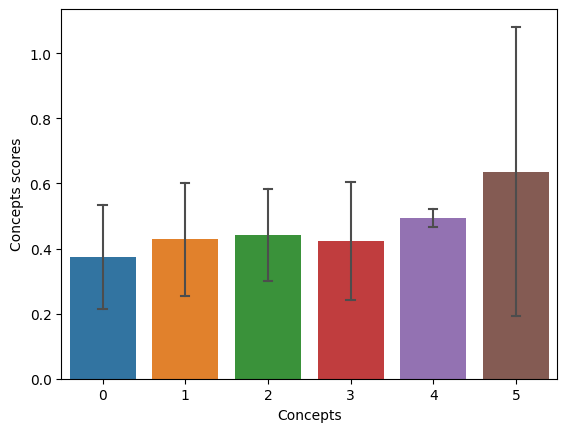

In [170]:
# Visualize concept scores
test_concept_scores_df = pd.DataFrame(test_concept_scores, columns=np.arange(6))

print('Shape of the concept scores: ', test_concept_scores.shape)

concept_scores_avg = test_concept_scores.mean(axis=0)
concept_scores_var = test_concept_scores.std(axis=0)

ax = sns.barplot(test_concept_scores_df, estimator='mean', errorbar='sd',
                 err_kws={"color": ".3", "linewidth": 1.5}, capsize=.1, 
                 legend=False, palette=palette)


ax.set(xlabel='Concepts', ylabel='Concepts scores')
plt.savefig(f'outputs/tabcbm_test_concept_scores_k{n_concepts}', dpi=300)
plt.show()



Evaluate concept scores of the models thta learned different number of concepts

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Shape of the concept scores:  (51830, 8)


C:\Users\sahat\AppData\Local\Temp\ipykernel_20952\842551771.py:12: UserWarning: The palette list has more values (12) than needed (8), which may not be intended.
  ax = sns.barplot(concept_scores_df, estimator='mean', errorbar='sd',


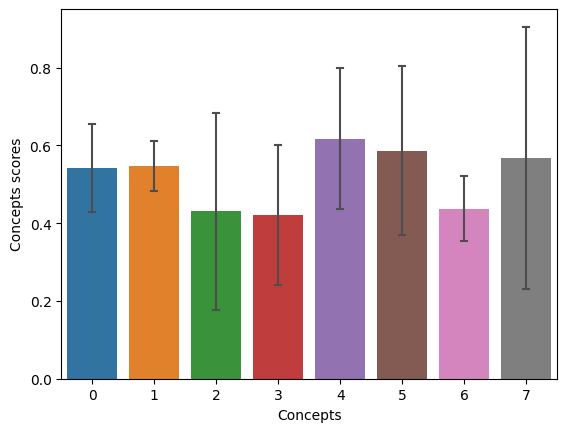

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Shape of the concept scores:  (51830, 10)


C:\Users\sahat\AppData\Local\Temp\ipykernel_20952\842551771.py:12: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  ax = sns.barplot(concept_scores_df, estimator='mean', errorbar='sd',


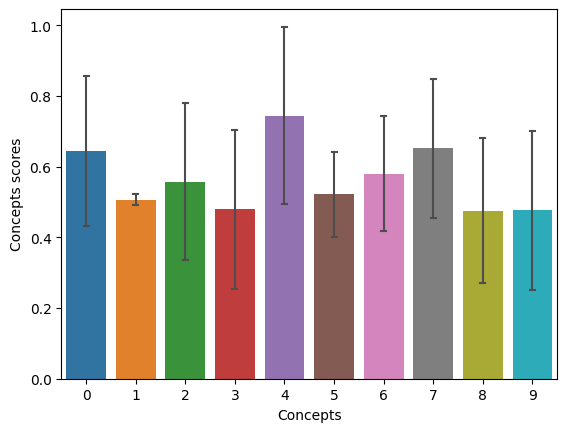

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Shape of the concept scores:  (51830, 12)


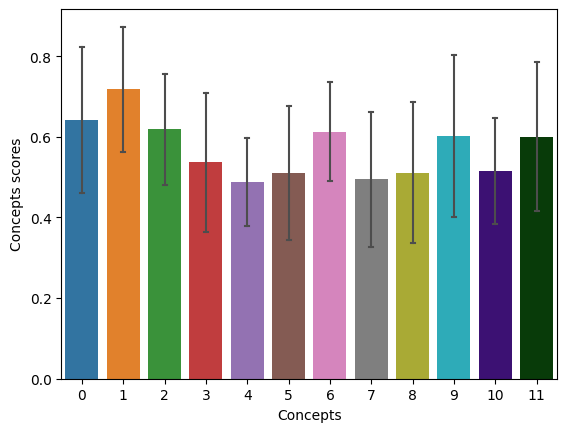

In [171]:
for tabcbm_model, n_concepts in zip(tabcbms_list, n_concepts_list):
    
    y_pred, concept_scores = tabcbm_model.predict(x_test, batch_size=batch_size)
    concept_scores_df = pd.DataFrame(concept_scores, columns=np.arange(n_concepts))

    # Visualize concept scores

    print('Shape of the concept scores: ', concept_scores.shape)

    concept_scores_avg = concept_scores.mean(axis=0)

    ax = sns.barplot(concept_scores_df, estimator='mean', errorbar='sd',
                    err_kws={"color": ".3", "linewidth": 1.5}, capsize=.1,
                    legend=False, palette=palette)

    ax.set(xlabel='Concepts', ylabel='Concepts scores')
    plt.savefig(f'outputs/tabcbm_test_concept_scores_k{n_concepts}', dpi=300)
    plt.show()

## Comparison of the calculated and ground-truth masks 

In [114]:
# The masks are stored as logits, so we need to turn them to probabilities using
# a sigmoid
masks = tf.sigmoid(tabcbm_supervised.feature_probabilities).numpy()

print('Features that correspond to the defined concepts:\n')
for concept, features in extended_concepts.items():
    print('\t', f'{concept}: {features}' )

print("\nThresholded concept masks learnt by TabCBM:")
for i, mask in enumerate((masks>0.0005).astype(np.int32)):
    print("\tFor concept", i, "we are selecting the following features", mask)
    print("\tThe folllowing features are masked by the model: \n\t", [feature for feature, flag in zip(x_train_std.columns, mask) if flag == 1], "\n" )
   
print("-" * 80)
print("-" * 80)
print("For comparison, the ground truth concept masks are")
for i, mask in enumerate(concepts_masks.to_numpy()):
    print("\tFor GROUND-TRUTH concept", i, " the following features are relevant\n\t", mask)



Features that correspond to the defined concepts:

	 Shipment: ['Type_CASH', 'Type_DEBIT', 'Type_PAYMENT', 'Type_TRANSFER', 'Days for shipment (scheduled)', 'Shipping Mode_First Class', 'Shipping Mode_Same Day', 'Shipping Mode_Second Class', 'Shipping Mode_Standard Class', 'Distance (km)']
	 Customer: ['Customer Zipcode', 'Customer Segment_Consumer', 'Customer Segment_Corporate', 'Customer Segment_Home Office']
	 Department: ['Department Name', 'Market_Africa', 'Market_Europe', 'Market_LATAM', 'Market_Pacific Asia', 'Market_USCA']
	 Store: ['Store Latitude', 'Store Longitude']
	 Order: ['Order Id', 'Order Longitude', 'Order Latitude', 'Benefit per order', 'Order Item Total', 'Order Status_CLOSED', 'Order Status_COMPLETE', 'Order Status_ON_HOLD', 'Order Status_PAYMENT_REVIEW', 'Order Status_PENDING', 'Order Status_PENDING_PAYMENT', 'Order Status_PROCESSING', 'Sales', 'Order Item Discount', 'order_year', 'order_month', 'order_day']
	 Product: ['Category Name']

Thresholded concept masks 

In [130]:
# The masks are stored as logits, so we need to turn them to probabilities using
# a sigmoid
masks = tf.sigmoid(tabcbm_supervised.feature_probabilities).numpy()

print('Features that correspond to the defined concepts:\n')
for concept, features in extended_concepts.items():
    print(f'{concept}: {features}' )

print("\nThresholded concept masks learnt by TabCBM:")
for i, mask in enumerate((masks>0.0005).astype(np.int32)):
    print("\tFor concept", i, "we are selecting the following features", mask)

    print("\t", [feature for feature, flag in zip(x_test.columns, mask) if flag == 1], "\n" )

print("-" * 80)
print("-" * 80)

print("For comparison, the ground truth concept masks are")
for i in range(tabcbm_supervised.n_concepts):
    print("\tFor GROUND-TRUTH concept", i, " the following features are relevant", concepts_masks.iloc[i, :].values)


Features that correspond to the defined concepts:

Shipment: ['Type_CASH', 'Type_DEBIT', 'Type_PAYMENT', 'Type_TRANSFER', 'Days for shipment (scheduled)', 'Shipping Mode_First Class', 'Shipping Mode_Same Day', 'Shipping Mode_Second Class', 'Shipping Mode_Standard Class', 'Distance (km)']
Customer: ['Customer Zipcode', 'Customer Segment_Consumer', 'Customer Segment_Corporate', 'Customer Segment_Home Office']
Department: ['Department Name', 'Market_Africa', 'Market_Europe', 'Market_LATAM', 'Market_Pacific Asia', 'Market_USCA']
Store: ['Store Latitude', 'Store Longitude']
Order: ['Order Id', 'Order Longitude', 'Order Latitude', 'Benefit per order', 'Order Item Total', 'Order Status_CLOSED', 'Order Status_COMPLETE', 'Order Status_ON_HOLD', 'Order Status_PAYMENT_REVIEW', 'Order Status_PENDING', 'Order Status_PENDING_PAYMENT', 'Order Status_PROCESSING', 'Sales', 'Order Item Discount', 'order_year', 'order_month', 'order_day']
Product: ['Category Name']

Thresholded concept masks learnt by Ta

In [166]:
trsh_masks = pd.DataFrame((masks>0.0001).astype(np.int32), columns=x_test.columns)

In [167]:
def color_true_red(val, color):
    return 'background-color: %s' % color if val == 1 else ''

In [168]:
learnt_concept_masks = pd.DataFrame(columns=[f for c, fs in extended_concepts.items() for f in fs])
for column in learnt_concept_masks.columns:
    learnt_concept_masks[column] = trsh_masks[column]

In [169]:
#styled_trsh_masks = trsh_masks.copy(deep=True)
style_obj = learnt_concept_masks.style
for i, (concept, features) in enumerate(extended_concepts.items()):
    style_obj = style_obj.map(color_true_red, subset=features, color=palette_hex[i])

header_style = [dict(selector="th", props=[('width', '10px')]),
                dict(selector="th.col_heading",
                     props=[("writing-mode", "vertical-rl"),
                            ('transform', 'rotateZ(180deg)'), 
                            ('height', '200px'),
                            ('vertical-align', 'bottom'),
                            ("width", '120px')]),
                dict(selector="", props=[("border", "1px solid")]),
                dict(selector="tbody td", props=[("border", "1px solid")]),
                dict(selector="th", props=[("border", "1px solid")])
]

style_obj.set_table_styles(header_style)

,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Days for shipment (scheduled),Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Distance (km),Customer Zipcode,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Store Latitude,Store Longitude,Order Id,Order Longitude,Order Latitude,Benefit per order,Order Item Total,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Sales,Order Item Discount,order_year,order_month,order_day,Category Name
0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [359]:
# Display the styled DataFrame
html_styled_trsh_masks = style_obj.to_html()
with open("thresholded_masks.html", "w") as f:
    f.write(html_styled_trsh_masks)

In [362]:
style_obj.to_excel('styled_thresholded_masks.xlsx', engine='openpyxl')

# Create thresholded masks with color indication for concepts

In [ ]:
# The masks are stored as logits, so we need to turn them to probabilities using
# a sigmoid
masks = tf.sigmoid(tabcbm_supervised.feature_probabilities).numpy()

print('Features that correspond to the defined concepts:\n')
for concept, features in extended_concepts.items():
    print(f'{concept}: {features}' )

print("\nThresholded concept masks learnt by TabCBM:")
for i, mask in enumerate((masks>0.0005).astype(np.int32)):
    print("\tFor concept", i, "we are selecting the following features", mask)

    print("\t", [feature for feature, flag in zip(x_train_std.columns, mask) if flag == 1], "\n" )

print("-" * 80)
print("-" * 80)

print("For comparison, the ground truth concept masks are")
for i in range(n_concepts):
    print("\tFor GROUND-TRUTH concept", i, " the following features are relevant", concepts_masks.iloc[i, :].values)


In [162]:
learnt_styled_dfs = []

for tabcbm_model, n_concepts in zip(tabcbms_list, n_concepts_list):

    gt_masks = tf.sigmoid(tabcbm_model.feature_probabilities).numpy()

    trsh_masks = pd.DataFrame((gt_masks>0.0001).astype(np.int32), columns=x_test.columns)

    learnt_concept_masks = pd.DataFrame(columns=[f for c, fs in extended_concepts.items() for f in fs])
    for column in learnt_concept_masks.columns:
        learnt_concept_masks[column] = trsh_masks[column]

    style_obj = learnt_concept_masks.style
    for i, (concept, features) in enumerate(extended_concepts.items()):
        style_obj = style_obj.map(color_true_red, subset=features, color=palette_hex[i])

    header_style = [dict(selector="th", props=[('width', '10px')]),
                    dict(selector="th.col_heading",
                        props=[("writing-mode", "vertical-rl"),
                                ('transform', 'rotateZ(180deg)'), 
                                ('height', '200px'),
                                ('vertical-align', 'bottom'),
                                ("width", '120px')]),
                    dict(selector="", props=[("border", "1px solid")]),
                    dict(selector="tbody td", props=[("border", "1px solid")]),
                    dict(selector="th", props=[("border", "1px solid")])
    ]

    style_obj.set_table_styles(header_style)
    learnt_styled_dfs.append(style_obj)

In [163]:
learnt_styled_dfs[0]

,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Days for shipment (scheduled),Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Distance (km),Customer Zipcode,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Store Latitude,Store Longitude,Order Id,Order Longitude,Order Latitude,Benefit per order,Order Item Total,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Sales,Order Item Discount,order_year,order_month,order_day,Category Name
0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,1,1,1,1,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [164]:
learnt_styled_dfs[1]

,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Days for shipment (scheduled),Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Distance (km),Customer Zipcode,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Store Latitude,Store Longitude,Order Id,Order Longitude,Order Latitude,Benefit per order,Order Item Total,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Sales,Order Item Discount,order_year,order_month,order_day,Category Name
0,1,0,0,0,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
5,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [165]:
learnt_styled_dfs[2]

,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Days for shipment (scheduled),Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Distance (km),Customer Zipcode,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Store Latitude,Store Longitude,Order Id,Order Longitude,Order Latitude,Benefit per order,Order Item Total,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Sales,Order Item Discount,order_year,order_month,order_day,Category Name
0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0
1,0,1,1,0,0,1,1,1,0,1,0,0,1,1,0,0,0,1,1,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0
2,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
5,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
9,0,1,1,0,1,1,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0
